In [1]:
import torch
import torch.nn as nn
from sklearn import datasets
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import math
import torch.nn.functional as F
import random

In [2]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(len(train_dataset))


60000


In [3]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64)

In [4]:
def remove_random_patches(images, patch_size=7):
    B, C, H, W = images.size()
    mask = torch.ones_like(images)  # Create a mask of ones
    targets = images.clone()
    for i in range(B):
        x = random.randint(0, H - patch_size)
        y = random.randint(0, W - patch_size)
        images[i, :, x:x+patch_size, y:y+patch_size] = 0.0  # Set patch to 0
        mask[i, :, x:x+patch_size, y:y+patch_size] = 0  # Update mask to 0 for removed patch
        targets[i, :, :, :] = images[i, :, :, :][mask == 1]

    return images, mask, targets

In [5]:

def remove_random_patches(images, patch_size=7):
    B, C, H, W = images.size()
    images = images.clone()
    mask = torch.ones_like(images)
    targets = torch.zeros(B, C, patch_size, patch_size)  # Hold the ground truth patches
    patch_masks = torch.zeros(B, (H // patch_size) * (W // patch_size))  # For transformer token mask

    for i in range(B):
        # Choose top-left corner of patch
        x = random.randint(0, H - patch_size)
        y = random.randint(0, W - patch_size)

        # Save the missing patch as target
        targets[i] = images[i, :, x:x+patch_size, y:y+patch_size].clone()

        # Zero out the patch in the image
        images[i, :, x:x+patch_size, y:y+patch_size] = 0.0
        mask[i, :, x:x+patch_size, y:y+patch_size] = 0

        # Compute which patch index was masked (for transformer token mask)
        px = x // patch_size
        py = y // patch_size
        patch_index = px * (W // patch_size) + py
        patch_masks[i, patch_index] = 1  # 1 = masked


    return images, mask, targets


In [6]:
# remove patch and display
import matplotlib.pyplot as plt
def show_image(image):
    image = image.squeeze().numpy()
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

In [7]:
class SelfAttention(nn.Module):
    def __init__(self, emb_size=256, heads=4, dropout=0.1):

        super().__init__()
        self.emb_size, self.heads = emb_size, heads
        self.key = nn.Linear(emb_size, emb_size, bias=False)
        self.query = nn.Linear(emb_size, emb_size, bias=False)
        self.value = nn.Linear(emb_size, emb_size, bias=False)
        self.unify_heads = nn.Linear(emb_size, emb_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        B, T, C = x.size()
        H = self.heads

        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        S = C // H

        k = k.view(B, T, H, S)
        q = q.view(B, T, H, S)
        v = v.view(B, T, H, S)

        k = k.transpose(1, 2).contiguous().view(B * H, T, S)
        q = q.transpose(1, 2).contiguous().view(B * H, T, S)
        v = v.transpose(1, 2).contiguous().view(B * H, T, S)

        dot = torch.bmm(q, k.transpose(1, 2)) # B * H, T, S) @ (B * H, S, T) -> (B * H, T, T)

        dot = dot / math.sqrt(S)

        # mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1)
        # dot = dot.masked_fill(mask == 1, float('-inf'))

        dot = F.softmax(dot, dim=2)

        dot = self.dropout(dot)
        out = torch.bmm(dot, v).view(B, H, T, S)

        out = out.transpose(1, 2).contiguous().view(B, T, S * H) # (B, H, T, S) -> (B, T, S * H) -> (B, T, C)

        out = self.unify_heads(out)

        return out

class TransformerBlock(nn.Module):
  def __init__(self, emb_size, heads, dropout=0.1):
    super().__init__()

    self.attention = SelfAttention(emb_size, heads)
    self.norm1 = nn.LayerNorm(emb_size)
    self.norm2 = nn.LayerNorm(emb_size)

    self.ff = nn.Sequential(
      nn.Linear(emb_size, 4 * emb_size),
      nn.ReLU(),
      nn.Linear(4 * emb_size, emb_size),
      nn.Dropout(dropout))

  def forward(self, x):
    x = x + self.attention(self.norm1(x))
    x = x + self.ff(self.norm2(x))
    return x

class Transformer(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, emb_size=64, heads=4, num_layers=6, dropout=0.1):
        super().__init__()
        assert emb_size % heads == 0
        self.emb_size = emb_size
        self.patch_size = patch_size
        self.heads = heads
        grid_size = img_size // patch_size  # 4

        # Embeddings
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)
        pos_x = torch.arange(grid_size).repeat(grid_size, 1)      # shape: (4, 4)
        pos_y = torch.arange(grid_size).view(grid_size, 1).repeat(1, grid_size)  # shape: (4, 4)
        coords = torch.stack([pos_x, pos_y], dim=-1).float()  # shape: (4, 4, 2)
        coords = coords.view(-1, 2)  # shape: (16, 2)
        self.coords = coords / (grid_size - 1)  # normalize to [0, 1]
        self.coord_embed = nn.Linear(2, emb_size)  # emb_size matches patch embedding size




        self.emb_dropout = nn.Dropout(dropout)
        self.pos_dropout = nn.Dropout(dropout)
        self.final_dropout = nn.Dropout(dropout)

        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(emb_size, heads, dropout=dropout) for _ in range(num_layers)]
        )
        self.reconstruct= nn.ConvTranspose2d(emb_size, in_channels, kernel_size=patch_size, stride=patch_size)
        #self.ff = nn.Linear(emb_size, 10)
        self.ff = nn.Linear(emb_size*grid_size*grid_size, img_size * img_size * in_channels)



    def forward(self, x, mask=None):
        B, C, H, W = x.size()
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        x = self.emb_dropout(x)

        pos = self.coord_embed(self.coords.to(x.device))  # (N, emb_size)
        x = x + pos

        for transformer in self.transformer_blocks:
            x = transformer(x)
        B, N, E = x.shape
        x_full = self.ff(x.reshape(B, N*E)).view(B,C,H,W)   # (B, N, patch_size*patch_size*in_channels)
        x_full = F.sigmoid(x_full)
        if mask is not None:
            x_patch = x_full[mask == 0].contiguous().view(B, C, self.patch_size, self.patch_size)


            x_full = x_full.masked_fill(mask == 1, 0)
        return x_full, x_patch

In [8]:
model = Transformer()

In [9]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = model.to('cuda')

In [10]:
def accuracy(y_pred, y):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y).sum().item()
    return correct / y.size(0)

In [11]:
for epoch in range(100):  # Keep it small for testing
    model.train()
    total_loss = 0
    for imgs, _ in train_loader:
        imgs, mask, target = remove_random_patches(imgs)  # Get images and mask
        imgs, mask, target = imgs.to('cuda'), mask.to('cuda'), target.to('cuda')
        _, logits = model(imgs, mask=mask)  # Reconstructed images
        loss = criterion(logits, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if loss < 0.0005:
            break

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")
    # print("Train accuracy:", accuracy(logits, labels))

Epoch 1, Loss: 0.0695
Epoch 2, Loss: 0.0553
Epoch 3, Loss: 0.0514
Epoch 4, Loss: 0.0491
Epoch 5, Loss: 0.0478
Epoch 6, Loss: 0.0467
Epoch 7, Loss: 0.0455
Epoch 8, Loss: 0.0444


KeyboardInterrupt: 

Image: 0


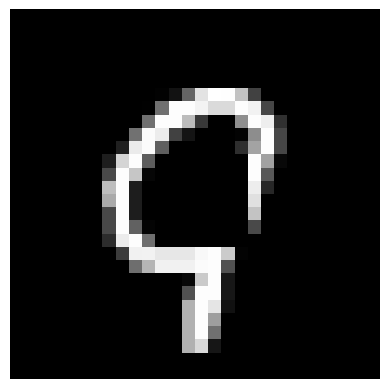

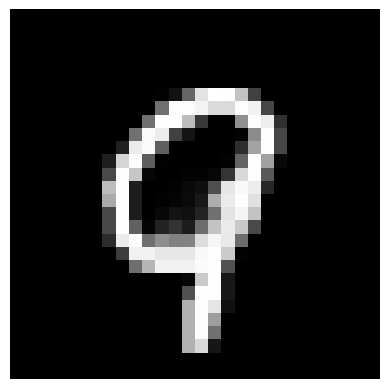

Image: 1


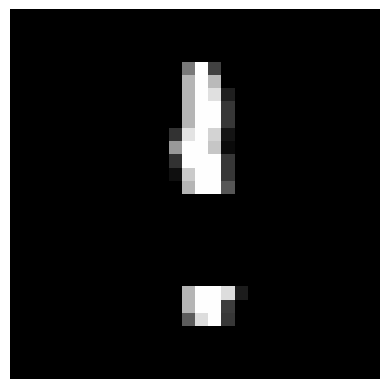

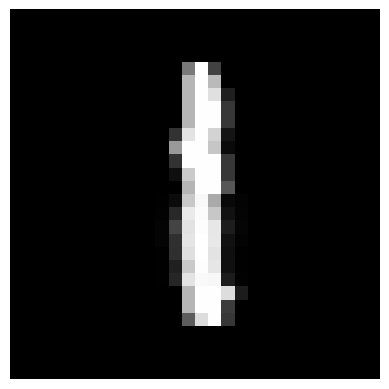

Image: 2


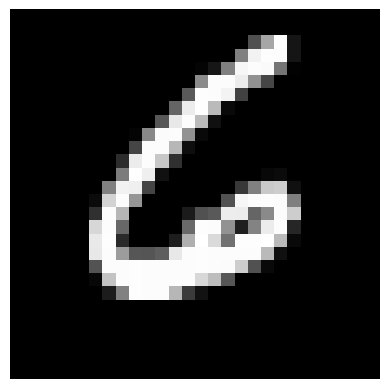

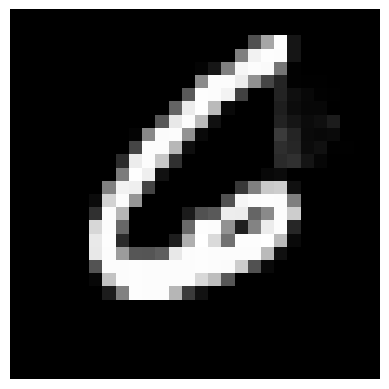

Image: 3


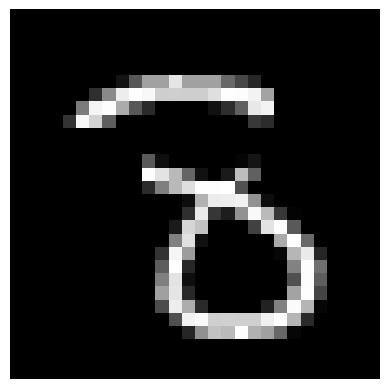

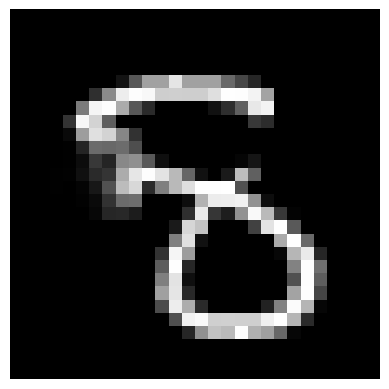

Image: 4


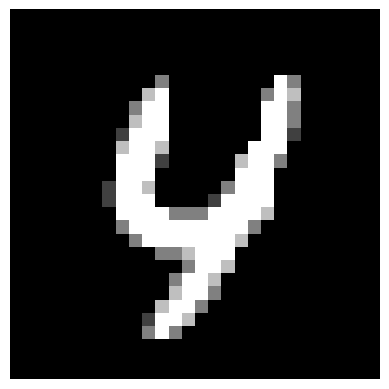

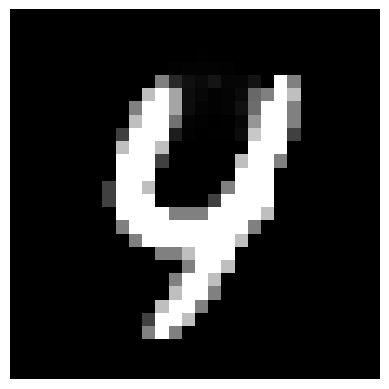

In [13]:
for imgs, labels in train_loader:
    imgs, mask, target = remove_random_patches(imgs)
    break

for i in range(5):
    print('Image:', i)
    #show_image(imgs[i] + target[i])
    show_image(imgs[i])
    #show_image(target[i])
    output = model(imgs[i].unsqueeze(0).to('cuda'), mask=mask[i].unsqueeze(0).to('cuda'))
    show_image(imgs[i].unsqueeze(0).detach().cpu() + output[0].detach().cpu())

